In [1]:
import tomopy
import matplotlib.pyplot as plt
import numpy as np
import k3d
import torch
# impoer resize 3D image
import tifffile as tiff
import glob
import tqdm
from natsort import natsorted
import os
from skimage.exposure import match_histograms
from skimage.transform import resize
from torchmetrics.image import PeakSignalNoiseRatio 
k3d.switch_to_text_protocol()
def normalize_01(images):
    images = (images- images.min()) / (images.max() - images.min())

    return images
def normalize_mean_std(images, mean=None, std=None):
    if mean is None or std is None:
        mean = images.mean()
        std = images.std()
    images = (images - mean) / std
    return images
def min_max_normalize(image, low_perc=0.05, high_perc=99.05):
    """Main pre-processing function used for the challenge (seems to work the best).
    Remove outliers voxels first, then min-max scale.
    """
    non_zeros = image > 0
    low, high = np.percentile(image[non_zeros], [low_perc, high_perc])
    image = np.clip(image, low, high)
    image = (image - low) / (high - low)
    return image

def flat_field_estimate(img, ratio_corners=0.03):

    height, width = img.shape
    # get corner size as 2% of the  dimension
    corner_size = int(min(height, width) * ratio_corners)

    # Extract the four corner regions (top-left, top-right, bottom-left, bottom-right)
    top_left = img[:corner_size, :corner_size]
    top_right = img[:corner_size, -corner_size:]
    bottom_left = img[-corner_size:, :corner_size]
    bottom_right = img[-corner_size:, -corner_size:]
    middle_left = img[height // 2 - corner_size // 2 : height // 2 + corner_size // 2, :corner_size]
    middle_right = img[height // 2 - corner_size // 2 : height // 2 + corner_size // 2, -corner_size:]
    corner_means = np.array(
        [
            top_left.mean(),
            top_right.mean(),
            bottom_left.mean(),
            bottom_right.mean(),
            middle_left.mean(),
            middle_right.mean(),
        ]
    )
    valid_corners = corner_means[
        (corner_means > np.percentile(corner_means, 10)) & (corner_means < np.percentile(corner_means, 90))
    ]
    flat_field_estimate = valid_corners.mean()

    return flat_field_estimate

In [ ]:
list_path = natsorted(glob.glob("datasets/raw_data/2024_08_01-transmission/2024_08_01-11-45-31_tr_400/*.tiff"))
os.makedirs("datasets/david_data_preprocessed_10x", exist_ok=True)
for image_path in tqdm.tqdm(list_path[::1]):
    image = tiff.imread(image_path)
    # write image to tif file
    tiff.imwrite(image_path.replace("2025_07_10-12-23-16", "2025_07_10-12-23-16_10x"), image)
    # break


  0%|          | 0/400 [00:00<?, ?it/s]


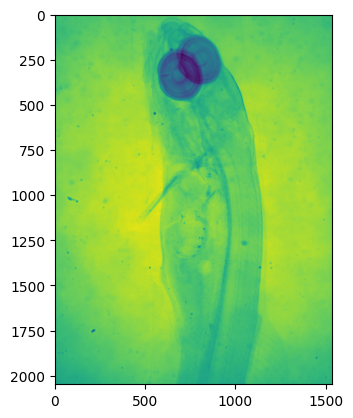

In [4]:
plt.imshow(image)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import k3d
import torch
# impoer resize 3D image
import tifffile as tiff
import glob
import tqdm
from natsort import natsorted
import os
from skimage.exposure import match_histograms
from skimage.transform import resize
from skimage import exposure
def normalize_01(images):
    images = (images- images.min()) / (images.max() - images.min())

    return images
ctf3 = natsorted(glob.glob("datasets/ctf3/*.tif"))
os.makedirs("datasets/stitched_2X_acc30x", exist_ok=True)
for image_path1 in tqdm.tqdm(ctf3[::30]):
    image1 = tiff.imread(image_path1)
    image2 = tiff.imread(image_path1.replace("ctf3", "ctf2"))
    image3 = tiff.imread(image_path1.replace("ctf3", "ctf1"))
    # increase the contrast by skimage
    # image1 = exposure.equalize_adapthist(image1, clip_limit=0.03)
    # image2 = exposure.equalize_adapthist(image2, clip_limit=0.03)
    # image3 = exposure.equalize_adapthist(image3, clip_limit=0.03)
    image2 = match_histograms(image2, image1, channel_axis=-1)
    image3 = match_histograms(image3, image1, channel_axis=-1)

    y_offset = 0
    img_height = image1.shape[0]
    stitched_image = np.zeros((img_height * 3, image1.shape[1]))
    x, y = 650, 700
    for i, img in enumerate([image1, image2, image3]):

        # stitched_image[y_offset:y_offset+img_height, :] = 0
        stitched_image[y_offset : y_offset + img_height, :] = img

        if i == 0:
            y_offset += img_height - x

        if i == 1:
            y_offset += img_height - y

    stitched_image = stitched_image[80 : -x - y - 450, :]

    # stitched_image = stitched_image - flat_field_estimate(stitched_image)
    # downscale the image to 1/2
    stitched_image = resize(stitched_image, (stitched_image.shape[0] // 2, stitched_image.shape[1] // 2), anti_aliasing=True)
    stitched_image = normalize_01(stitched_image)
    stitched_image = exposure.equalize_adapthist(stitched_image, clip_limit=0.04)
    stitched_image = stitched_image.max() - stitched_image
    stitched_image = normalize_01(stitched_image)
    # convert to 16 bit
    stitched_image = (stitched_image * 65535).astype(np.uint16, copy=False)
    tiff.imsave(image_path1.replace("ctf3", "stitched_2X_acc30x"), stitched_image)
    break

  0%|          | 0/61 [00:00<?, ?it/s]/tmp/ipykernel_1837677/294377721.py:57: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(image_path1.replace("ctf3", "stitched_2X_acc30x"), stitched_image)
  0%|          | 0/61 [00:01<?, ?it/s]


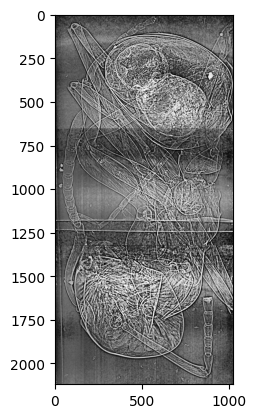

In [75]:
plt.imshow(stitched_image, cmap="gray")

In [2]:
# get sinogram from the folder
data_path = natsorted(glob.glob("datasets/stitched_2X_acc10x/*.tif"))
sinogram = []
for image_path in tqdm.tqdm(data_path):
    # read the image
    image = tiff.imread(image_path)
    sinogram.append(image)

sinogram = np.array(sinogram)
sinogram = sinogram.astype(np.float32, copy=False)
sinogram = sinogram / 65535.0


100%|██████████| 180/180 [00:00<00:00, 966.27it/s]


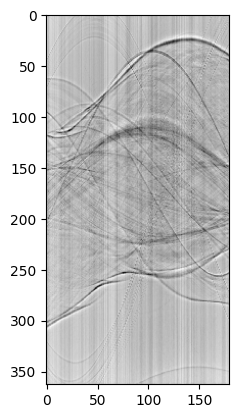

In [11]:
a = tiff.imread("/home/nhattm/ToMoDL/sinos_slice(200, 201, None).tif")
plt.imshow(a, cmap="gray")

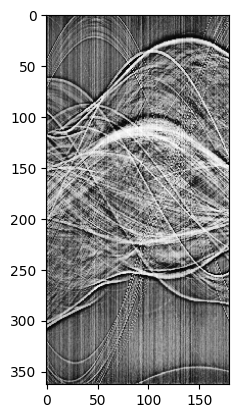

In [ ]:
image1 = tiff.imread("datasets/ctf3/0001.tif")
image2 = tiff.imread("datasets/ctf2/0001.tif")
image3 = tiff.imread("datasets/ctf1/0001.tif")
print(np.max(image2), np.min(image2))
image2 = match_histograms(image2, image1, channel_axis=-1)
print(np.max(image2), np.min(image2))

image3 = match_histograms(image3, image1, channel_axis=-1)
y_offset = 0
img_height = image1.shape[0]
stitched_image = np.zeros((img_height*3, image1.shape[1]))
x, y = 650, 700
for i, img in enumerate([image1, image2, image3]):

    # stitched_image[y_offset:y_offset+img_height, :] = 0
    stitched_image[y_offset:y_offset+img_height, :] = img

    if i == 0:
        y_offset += img_height-x

    if i == 1:
        y_offset += img_height-y

stitched_image = stitched_image[100:-x-y-450, :]
stitched_image = stitched_image / flat_field_estimate(stitched_image)
stitched_image = normalize_01(stitched_image)

In [25]:
a1 = tiff.imread("datasets/ctf3/0001.tif")
# a1 = normalize_01(a1)
a2 = tiff.imread("datasets/ctf2/0001.tif")
# a2 = normalize_01(a2)
a3 = tiff.imread("datasets/ctf1/0001.tif")
# a3 = normalize_01(a3)
# merge 3 images in x axis
a = np.concatenate((a1,a2,a3),axis=0)

-0.06515795 -1.621023
-0.09773167 -2.4574053


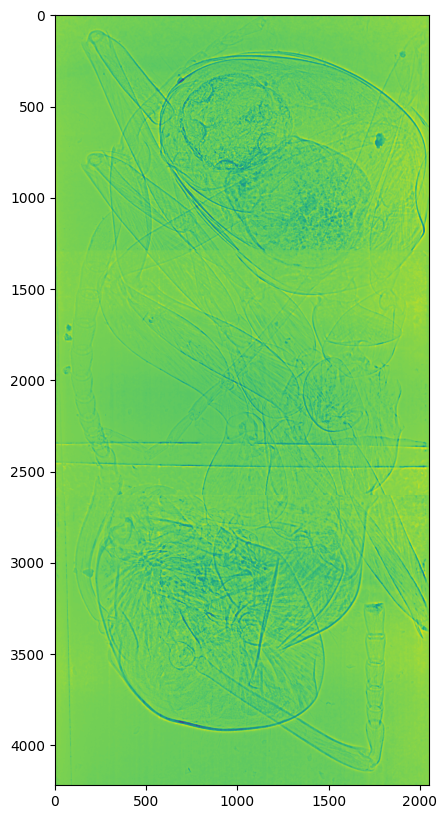

In [ ]:
image1 = tiff.imread("datasets/ctf3/0001.tif")
image2 = tiff.imread("datasets/ctf2/0001.tif")
image3 = tiff.imread("datasets/ctf1/0001.tif")
print(np.max(image2), np.min(image2))
image2 = match_histograms(image2, image1, channel_axis=-1)
print(np.max(image2), np.min(image2))

image3 = match_histograms(image3, image1, channel_axis=-1)
y_offset = 0
img_height = image1.shape[0]
stitched_image = np.zeros((img_height*3, image1.shape[1]))
x, y = 650, 700
for i, img in enumerate([image1, image2, image3]):

    # stitched_image[y_offset:y_offset+img_height, :] = 0
    stitched_image[y_offset:y_offset+img_height, :] = img

    if i == 0:
        y_offset += img_height-x

    if i == 1:
        y_offset += img_height-y

stitched_image = stitched_image[100:-x-y-450, :]
stitched_image = stitched_image / flat_field_estimate(stitched_image)
stitched_image = normalize_01(stitched_image)
figure = plt.figure(figsize=(10, 10))
plt.imshow(stitched_image)

In [90]:
stitched_image.min(), stitched_image.max()

(0.0, 1.0)

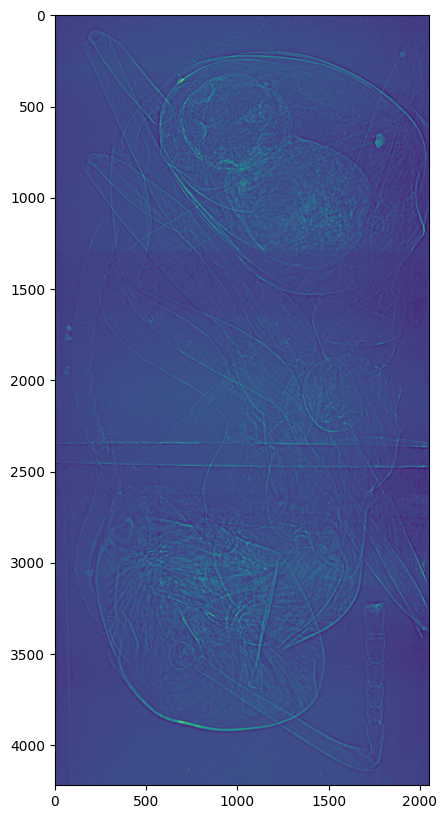

In [96]:
stitched_image = stitched_image / flat_field_estimate(stitched_image)
stitched_image = normalize_01(stitched_image)
figure = plt.figure(figsize=(10, 10))
plt.imshow(stitched_image)

In [5]:
# read tif file
import tifffile as tiff
import glob
import tqdm
import os
import cv2
os.makedirs("/home/nhattm/ToMoDL/datasets/ctf1_cut_10x", exist_ok=True)
resize_factor = 2
file_names = natsorted(glob.glob("/home/nhattm/ToMoDL/datasets/ctf1/*.tif"))
sinos = []
for file_name in tqdm.tqdm(file_names[::10]):
    sino = tiff.imread(file_name)
    sino = np.asarray(sino)[:1600]
    sino = sino.astype(np.float32)
    # sino = sino[:1700, :]
    # sino = cv2.resize(sino, (sino.shape[1]//resize_factor, sino.shape[0]//resize_factor))
    # sino = resize(sino, (sino.shape[0]//resize_factor, sino.shape[1]//resize_factor), anti_aliasing=True)
    tiff.imwrite(f"/home/nhattm/ToMoDL/datasets/ctf1_cut_10x/{file_name.split('/')[-1]}", sino)
    sinos.append(sino)

sinos = np.stack(sinos)

100%|██████████| 180/180 [00:04<00:00, 38.43it/s]


In [13]:
flat.min(), flat.max()

(1448, 3833)

In [27]:
def flat_field_correction(image, flat_field, dark_field):
    """
    Corrects an image using flat field and dark field images.

    Args:
        image (numpy.ndarray): The raw image to be corrected.
        flat_field (numpy.ndarray): The flat field image.
        dark_field (numpy.ndarray): The dark field image.

    Returns:
        numpy.ndarray: The corrected image.
    """

    
    # Correct the flat field and raw image
    corrected_flat = flat_field - dark_field
    corrected_image = image - dark_field

    # Handle potential division by zero
    zero_indices = corrected_flat == 0
    corrected_flat[zero_indices] = 1e-6  # Add a small value to avoid division by zero

    # Normalize the flat field
    median_flat = np.median(corrected_flat)
    normalized_flat = corrected_flat / median_flat

    # Apply flat field correction
    corrected_image = corrected_image / normalized_flat
    # invert the image
    corrected_image = corrected_image.max() - corrected_image
    return corrected_image

100%|██████████| 400/400 [00:30<00:00, 13.20it/s]


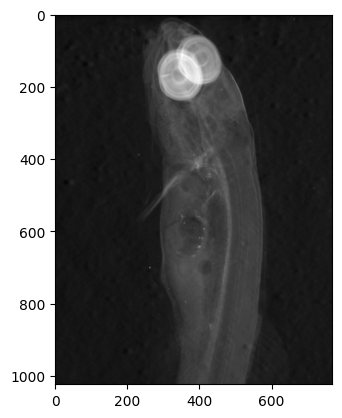

In [29]:
resize_factor = 2
file_names = natsorted(glob.glob("datasets/raw_data/2024_08_01-transmission/2024_08_01-11-45-31_tr_400/*.tiff"))
sinos = []
os.makedirs(f"datasets/david_preprocessed_2024_08_01-11-45-31_tr_400", exist_ok=True)
flat = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-01-01_flat_field.tiff")
dark = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-02-29_dark_field.tiff")
for file_name in tqdm.tqdm(file_names):
    image = tiff.imread(file_name)
    image = np.asarray(image)

    image = flat_field_correction(image, flat, dark)
    image = resize(image, (image.shape[0]//resize_factor, image.shape[1]//resize_factor), anti_aliasing=True)
    sinos.append(image)
    # save as tif file
    tiff.imwrite(f"datasets/david_preprocessed_2024_08_01-11-45-31_tr_400/{file_name.split('/')[-1]}", image)
    # break
sinos = np.stack(sinos)
# sinos = normalize_01(sinos)

plt.imshow(sinos[0, :, :], cmap="gray")

In [31]:
sinos.shape

(50, 1024, 768)

100%|██████████| 50/50 [00:03<00:00, 13.45it/s]


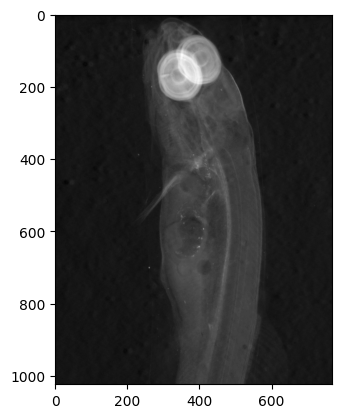

In [30]:
resize_factor = 2
file_names = natsorted(glob.glob("datasets/raw_data/2024_08_01-transmission/2024_08_01-11-48-43_tr_50/*.tiff"))
sinos = []
os.makedirs(f"datasets/david_preprocessed_2024_08_01-11-48-43_tr_50", exist_ok=True)
flat = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-01-01_flat_field.tiff")
dark = tiff.imread("datasets/raw_data/2024_08_01-transmission/2024_08_01-12-02-29_dark_field.tiff")
for file_name in tqdm.tqdm(file_names):
    image = tiff.imread(file_name)
    image = np.asarray(image)

    image = flat_field_correction(image, flat, dark)
    image = resize(image, (image.shape[0]//resize_factor, image.shape[1]//resize_factor), anti_aliasing=True)
    sinos.append(image)
    # save as tif file
    tiff.imwrite(f"datasets/david_preprocessed_2024_08_01-11-48-43_tr_50/{file_name.split('/')[-1]}", image)
    # break
sinos = np.stack(sinos)
# sinos = normalize_01(sinos)

plt.imshow(sinos[0, :, :], cmap="gray")

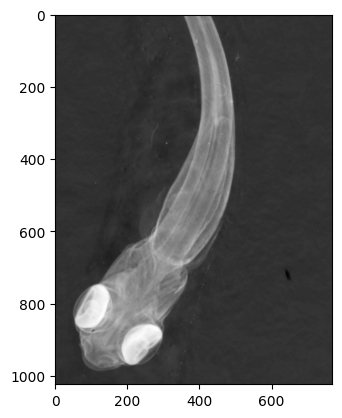

In [42]:
plt.imshow(sinos[-1, :, :], cmap="gray")


In [26]:
sinos.min(), sinos.max(), sinos.shape

(-3.0340028, 0.41573137, (1800, 1020, 1024))

In [67]:
# height, width = sinos.shape[1], sinos.shape[2]
# img = sinos[0]

img = stitched_image
height, width = stitched_image.shape[0], stitched_image.shape[1]

corner_size = int(min(height, width) * 0.03)

# Extract the four corner regions (top-left, top-right, bottom-left, bottom-right)
top_left = img[:corner_size, :corner_size]
top_right = img[:corner_size, -corner_size:]
bottom_left = img[-corner_size:, :corner_size]
bottom_right = img[-corner_size:, -corner_size:]
middle_left = img[height//2-corner_size//2:height//2+corner_size//2, :corner_size]
middle_right = img[height//2-corner_size//2:height//2+corner_size//2, -corner_size:]
corner_means = np.array([top_left.mean(), top_right.mean(), bottom_left.mean(), bottom_right.mean(), middle_left.mean(), middle_right.mean()])
valid_corners = corner_means[(corner_means > np.percentile(corner_means, 10)) & (corner_means < np.percentile(corner_means, 90))]
flat_field_estimate = valid_corners.mean()


sinos_normalized = stitched_image / flat_field_estimate
# sinos_normalized = normalize_01(sinos_normalized)
# sinos_normalized = -np.log10(sinos_normalized +1e-4)
sinos_normalized = normalize_01(sinos_normalized)

In [28]:
flat_field_estimate

-0.36823377

In [29]:
sino2 = sinos / flat_field_estimate
sino2 = normalize_01(sino2)

In [11]:
sinos_normalized.min(), sinos_normalized.max()

(0.0, 1.0)

In [22]:
corner_size = int(min(height, width) * 0.03)

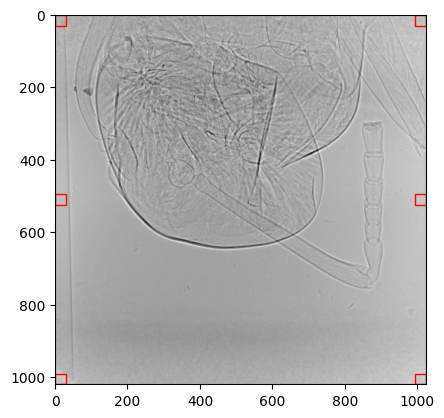

In [30]:
import matplotlib.patches as patches

# Display the first sinogram
fig, ax = plt.subplots(1)
ax.imshow(sinos[0], cmap="gray")

# Draw rectangles around the corners
rect_top_left = patches.Rectangle((0, 0), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_top_right = patches.Rectangle((width - corner_size, 0), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_bottom_left = patches.Rectangle((0, height - corner_size), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_bottom_right = patches.Rectangle((width - corner_size, height - corner_size), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_middle_left = patches.Rectangle((0, height//2 - corner_size//2), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
rect_middle_right = patches.Rectangle((width - corner_size, height//2 - corner_size//2), corner_size, corner_size, linewidth=1, edgecolor='r', facecolor='none')
# Add the rectangles to the plot
ax.add_patch(rect_top_left)
ax.add_patch(rect_top_right)
ax.add_patch(rect_bottom_left)
ax.add_patch(rect_bottom_right)
ax.add_patch(rect_middle_left)
ax.add_patch(rect_middle_right)

plt.show()


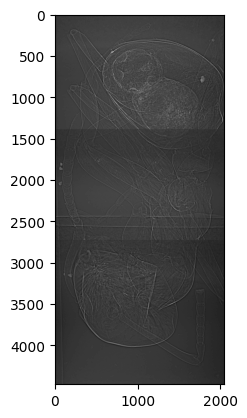

In [68]:
plt.imshow(sinos_normalized, cmap="gray")

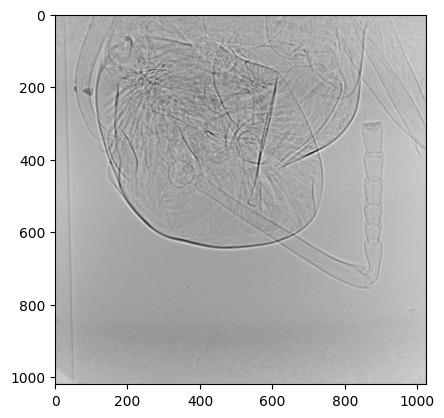

In [35]:
plt.imshow(sinos[0], cmap="gray")

In [17]:
sinos_normalized.shape

(1800, 102, 102)

In [43]:
theta = tomopy.angles(sinos.shape[0])
rot_center = tomopy.find_center(sinos, theta, init=290, ind=0, tol=0.5)
print(rot_center)

[-132.3125]


In [44]:

recon = tomopy.recon(sinos, theta, center=rot_center, algorithm='gridrec', sinogram_order=False)
rec = tomopy.circ_mask(rec, axis=0, ratio=0.95)
# rec = rec.max() - rec
rec = (rec - rec.min()) / (rec.max() - rec.min())
rec = rec * (2**16 - 1)
rec = rec.astype(np.uint16)
tiff.imwrite("/home/nhattm/david_data.tif", rec)

In [17]:
rec.min(), rec.max()

(0, 65535)

In [168]:
# normalize the reconstruction from 0 to 255


# save the reconstruction

In [40]:
import napari
from dask_image.imread import imread

# stack = imread("/home/nhattm/opt_volume_filter.tif")
napari.view_image(rec)

Viewer(camera=Camera(center=(0.0, 511.5, 511.5), zoom=0.5199205306132983, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(509.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 1020.0, 1.0), (0.0, 1024.0, 1.0), (0.0, 1024.0, 1.0)), current_step=(509, 511, 511), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'rec' at 0x713a298f6350>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x713a1fdb9480>], _persisted_mouse_event={}, _mouse_drag_gen={}, _mouse_wheel_gen={}, keymap={})

In [10]:
#save the reconstruction


In [ ]:
rec.shape

In [ ]:
#plot the reconstruction 3Dvolume with matplotlib
plt.show(rec)

In [ ]:
# import tifffile as tiff
# import glob
# import tqdm
# from natsort import natsorted
# from PIL import Image
# file_names = natsorted(glob.glob("/home/nhattm/ToMoDL/datasets/student_data/*.jpg"))
# sinos = []
# for file_name in tqdm.tqdm(file_names):
#     sino = Image.open(file_name)
#     sino = np.asarray(sino)
#     sino = sino.astype(np.float32)
#     sinos.append(sino)

# sinos = np.stack(sinos)

In [136]:
# sinos = tomopy.minus_log(sinos)


In [ ]:
plt.imshow(sinos[:,100, :], cmap="gray")
plt.show()

In [ ]:
extra_options = {'MinConstraint': 0}
options = {
    # 'proj_type': 'cuda',
    # "filter_name": "ramlak",

    # 'num_iter': 200,
    # 'extra_options': extra_options,
    # "accelerated": True
}
# rec = tomopy.recon(sinos,theta, algorithm="gridrec",filter_name= "ramlak")
batch_size = 1
batch_start = 0
batch_end = batch_start + batch_size
recs = []
while batch_end <= sinos.shape[0]:
    rec = tomopy.recon(sinos[batch_start:batch_end],theta[batch_start:batch_end], algorithm="gridrec",filter_name= "ramlak")
    recs.append(rec)
    batch_end = batch_start + batch_size
    batch_start = batch_end
    
recs = np.stack(recs)

In [ ]:
#save the reconstruction
tiff.imwrite("reconstruction.tif", rec)


In [ ]:
# build a widget to show the reconstruction
from ipywidgets import interact

def show_recon(i):
    plt.imshow(rec[i], cmap="gray")
    plt.show()

interact(show_recon, i=(0, rec.shape[0]-1))

In [6]:

# run this block again if nothing appear
plt_volume = k3d.volume(rec.astype(np.float16),
                        alpha_coef=5.,
                        samples=128,
                        ray_samples_count=4,
                        interpolation=True,
                        compression_level=9,
                        )

plot = k3d.plot()
plot += plt_volume

plot.display() # You can also just use 'plot'

In [2]:
# open tiff file with napari
import tifffile as tiff
tiff_file = "/home/nhattm/FBP_100.tif"
tiff_file = tiff.imread(tiff_file)
# import napari
# viewer = napari.view_image(tiff_file)


<tifffile.TiffFile 'FBP_100.tif'> shaped series failed to reshape, raised ValueError('cannot reshape (1448, 1448) to (1700, 1448, 1448)')


In [3]:
tiff_file.shape

(1448, 1448)